# Top Model

### Import Preliminaries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tqdm import *

# Import Data
test_data = pd.read_csv('Data/test.csv', low_memory=False)
train_data = pd.read_csv('Data/train.csv', low_memory=False)

train_df_classes = train_data['project_is_approved']


# Training Features
features = ['teacher_prefix', 'school_state', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories',
            'teacher_number_of_previously_posted_projects']

train_df = train_data[features]
test_df = test_data[features]
train_df = train_df.fillna(value='No Essay')
test_df = test_df.fillna(value='No Essay')

### Encoding Values

In [2]:
for col in list(train_df.select_dtypes('object').columns):
    train_df[col] = train_df[col].astype('category')
    train_df[col] = train_df[col].cat.codes
    
for col in list(test_df.select_dtypes('object').columns):
    test_df[col] = test_df[col].astype('category')
    test_df[col] = test_df[col].cat.codes

### Dataframe to Values

In [3]:
y = train_df_classes.values
X = train_df.values
X_test = test_df.values

### Setup Logisical Model

In [4]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Logistical Model

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

crossvalidation = KFold(10, random_state=1)
scores = cross_val_score(model, X, y, 
                scoring = 'accuracy',
                cv = crossvalidation, n_jobs =1)

print ('Folds: %i,accuracy: %.2f std: %.2f' 
% (len(scores),np.mean(np.abs(scores)),np.std(scores)))

Folds: 10,accuracy: 0.85 std: 0.00


### Prediction Model

In [6]:
logpred = pd.Series(model.predict(X_test), name='logistic feature')
logpred.head(5)

0    1
1    1
2    1
3    1
4    1
Name: logistic feature, dtype: int64

### Essay Data

In [7]:
# Taining Data
essay_features = ['project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary']

train_df = train_data[essay_features]
test_df = test_data[essay_features]

train_df = train_data[essay_features]
test_df = test_data[essay_features]
train_df = train_df.fillna(value='No Essay')
test_df = test_df.fillna(value='No Essay')

In [8]:
train_df.sample(3)

,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary
158079,I teach students that come from poverty. The b...,I am a teacher in a Title 1 school. Eighty % o...,The students in my classroom tend to respond t...,Students who enter my classroom are at a disad...,My students need a model of the human body tor...
14822,A typical day in my classroom is very busy. We...,Parents are their children's first teacher(s) ...,No Essay,No Essay,My students need books to share with their fam...
30644,I am a first year kindergarten teacher at a Ti...,My students need books with CDs for our listen...,No Essay,No Essay,My students need a variety of books with CDs f...


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 10000
maxlen = 500
validation_split = 0.2
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_df.project_essay_1.values)
sequences = tokenizer.texts_to_sequences(train_df.project_essay_1.values)

word_index = tokenizer.word_index
essay_one_data = pad_sequences(sequences, maxlen=maxlen)
essay_one_data = pd.DataFrame(essay_one_data)
essay_one_data = pd.concat([essay_one_data, train_df_classes], axis=1)
essay_one_data.head(10)

Using TensorFlow backend.


,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,project_is_approved
0,0,0,0,0,0,0,0,0,0,0,...,1,156,3,790,22,43,256,25,417,1
1,0,0,0,0,0,0,0,0,0,0,...,1,14,1646,279,151,400,739,1339,719,0
2,0,0,0,0,0,0,0,0,0,0,...,3583,3,4,8,204,1,32,9,18,1
3,0,0,0,0,0,0,0,0,0,0,...,6,165,5,594,21,107,893,382,678,0
4,0,0,0,0,0,0,0,0,0,0,...,112,238,17,671,848,1305,1771,1,572,1
5,0,0,0,0,0,0,0,0,0,0,...,11,147,53,67,146,9,18,9,18,1
6,0,0,0,0,0,0,0,0,0,0,...,10,28,26,137,26,6,582,1628,170,1
7,0,0,0,0,0,0,0,0,0,0,...,175,1,55,206,326,15,190,900,112,1
8,0,0,0,0,0,0,0,0,0,0,...,61,316,37,1,223,1,549,50,1278,1
9,0,0,0,0,0,0,0,0,0,0,...,2,870,23,26,511,9,18,9,18,1


In [10]:
essay_one_features = essay_one_data.columns[:-1]
print('Traing Data Shape:', essay_one_data[essay_one_features].shape)
print('Traing Data Shape:', essay_one_data['project_is_approved'].shape)
X = essay_one_data[essay_one_features].values
y = essay_one_data['project_is_approved'].values
max_words = essay_one_features[0]

Traing Data Shape: (182080, 500)
Traing Data Shape: (182080,)


### Recurrent Layer in Keras

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

max_features
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(input_train, y_train
                    ,epochs=30, batch_size=128, validation_split=0.2)

NameError: name 'input_train' is not defined

### Other options 
 - full state sequence
 - Stack several reccurent layers

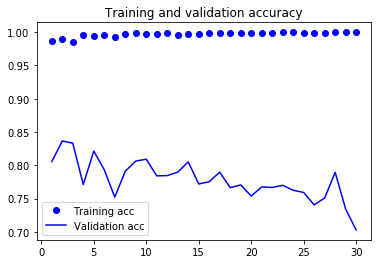

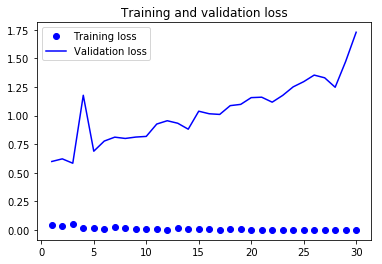

In [258]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()